**Notes from kick-off meeting**
- dry season (Jan-Apr) is irrelevant for precip - wet season (May-Dec) largely irrelevant for PET
- PET is expected to be insignificant compared to water usage - typically about 1-3mm/day in wet season, 5-8mm/day in dry season
- temperatures have increased by about 1C in this region (2C for nighttime temperatures) - no change in windspeed or direction
- use ACP core stations (50 or so) within the watershed - could also include coastal stations from STRI but these tend to be shorter duration
- El Nino has strong correlation with dry years - La Nina is less strongly linked to wet years (although variability is higher in wet years)  
&nbsp;
- over long time series there's clear evidence of a decadal oscillation - which may be linked to the AMO
- December precip was very low this year: maybe that would also be worth looking at? (Also May, which has more of an effect on lake levels dropping - December more important for replenishment)
&nbsp;
- an interesting follow-up question: what happens in the second half of the second year? This is when replenishment should occur

In [1]:
import sys; sys.path.append('..'); from wwa import *
from scipy.stats import spearmanr, pearsonr
import calendar

warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", message = ".+naturalearth.+")

mapproj = cartopy.crs.PlateCarree()
# xn, xx, yn, yx = [-80.25,-79.25,8.7,9.7] # original bounds
xn, xx, yn, yx = [-80.25,-79.25,8.7,9.7] # revised after comparison with station data

bci_px = {"lon" : -79.838234, "lat" : 9.163114}

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
gridlines = [i+1 for i in range(366) if (days[i].day) == 1]
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

sf = gpd.read_file("sf_hybas06").clip((xn, xx, yn, yx))

# Physical geography

In [33]:
elev = xr.open_dataset("data/gebco_2023_n11.0_s6.0_w-85.0_e-75.0.nc").elevation

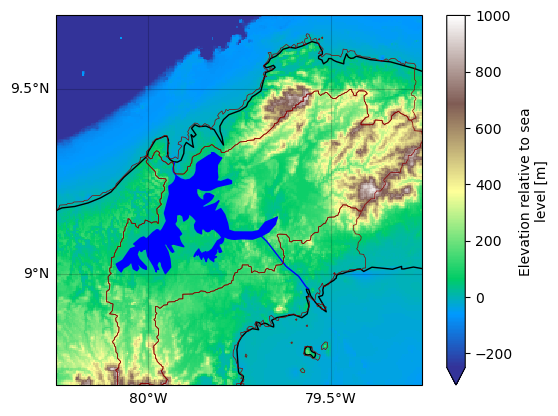

In [34]:
elev.sel(lon = slice(xn,xx), lat = slice(yn,yx)).plot(cmap = "terrain", vmax = 1000, vmin = -250, subplot_kws = {"projection" : mapproj, "extent" : (xn, xx, yn, yx)})
ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.LAKES, color = "blue")
ax.add_feature(cartopy.feature.RIVERS, color = "blue")
ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))
sf.boundary.plot(ax = ax, color = "darkred", lw = 0.5)

plt.savefig("fig/elevation.png")

---
# Lake levels
https://evtms-rpts.pancanal.com/eng/h2o/index.html (https://pancanal.com/en/)

- the three driest years observed were 1997, 2015 and 2023 (in order of accumulated precip deficit by September)  
- in all three of these years, the lake levels were roughly the same at the start of the year (about 87.5ft) -
the 2023 level has dropped much more quickly than in either 1997 or 2015.  
&nbsp;
- Jun-Sep 2023 is the longest that levels have remained this low.
&nbsp;
- previously, the lowest levels have occurred in April-June of the years following the lowest precipitation, then recovered quickly.  
This suggests that next year, levels might be even lower.


In [288]:
df = pd.read_csv("data/Download_Gatun_Lake_Water_Level_History.csv", parse_dates = ["DATE_LOG"], index_col = 0)
df = df.rename(columns = {"GATUN_LAKE_LEVEL(FEET)" : "level"})

In [289]:
df.loc[df.level == 0, "level"] = np.nan # remove zeros

In [290]:
df[np.abs(df - df.rolling(15).mean()) > 1] = np.nan # remove any readings that are more than 1ft from the smoothed line (seems implausible)

Text(0.5, 1.0, 'Distribution of lake levels at start of year')

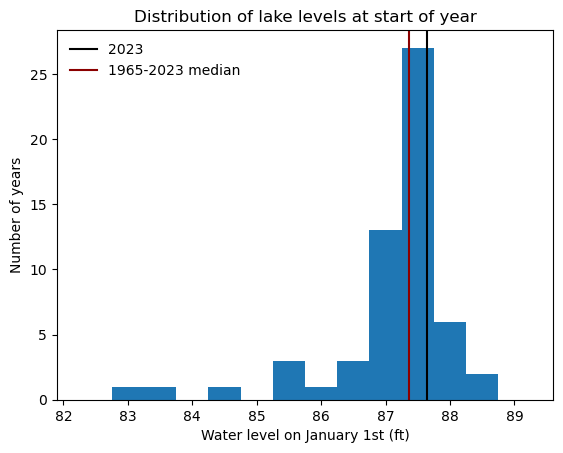

In [291]:
# lake level at start of each year - 2023 not particularly unusual - in fact, above the median level
df.loc[df.index.day_of_year == 1].hist(grid = False, bins = np.arange(82.25, 89.75,0.5))

# df.loc[df.index.day_of_year == 1].loc[slice("1990","2020")].hist(ax = plt.gca(), grid = False, bins = np.arange(82.25, 89.75,0.5), alpha = 0.3, color = "darkblue")

plt.gca().axvline(df.loc["2023-01-01", "level"], color = "k", label = "2023")
plt.gca().axvline(df.loc[df.index.day_of_year == 1, "level"].median(), color = "darkred", label = "1965-2023 median")

plt.legend(edgecolor = "w")

plt.xlabel("Water level on January 1st (ft)")
plt.ylabel("Number of years")
plt.title("Distribution of lake levels at start of year")
# plt.savefig("fig/starting-level-histogram.png")

In [292]:
df_proj = pd.read_csv("data/Gatun_Water_Level_Projection.csv", skiprows = 3, header = None, names = ["proj_date", "level", "surcharge", "maxd_1", "maxd_2"],
           index_col = 0, parse_dates = [0]).sort_values("proj_date")[["level"]]

In [293]:
df_clim = df.loc[slice("1990", "2020")].groupby(df.loc[slice("1990", "2020")].index.day_of_year).mean()

/tmp/ipykernel_79551/3576814080.py:40: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7effa9427d00> starts with '_'. It is thus excluded from the legend.
  plt.gcf().legend(["1990-2020 mean", "2023-24", "_", "1981-2022"], bbox_to_anchor = (0.9,0.6), loc = "center left", edgecolor = "w")


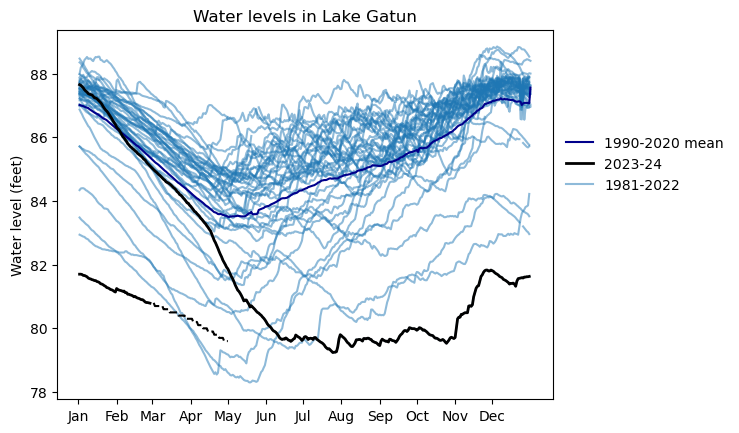

In [303]:
df_clim.plot(color = "darkblue", legend = False)
ax = plt.gca()
   
ts_y = df.loc[str(2023)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "k", legend = False, lw = 2)

ts_y = df.loc[str(2024)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "k", legend = False, lw = 2)

# ts_y = df.loc[str(1997)]
# ts_y.index = ts_y.index.day_of_year
# ts_y.plot(ax = ax, color = "darkorange", legend = False)

# ts_y = df.loc[str(1998)]
# ts_y.index = ts_y.index.day_of_year
# ts_y.plot(ax = ax, color = "darkorange", legend = False, ls = "--")

# ts_y = df.loc[str(2015)]
# ts_y.index = ts_y.index.day_of_year
# ts_y.plot(ax = ax, color = "darkred", legend = False)

# ts_y = df.loc[str(2016)]
# ts_y.index = ts_y.index.day_of_year
# ts_y.plot(ax = ax, color = "darkred", legend = False, ls = "--")

for y in range(1981, 2024):
    ts_y = df.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ts_y.plot(ax = ax, color = "tab:blue", alpha = 0.5, legend = False, label = "_", zorder = -99)
    

for y in range(2024, 2025):
    ts_y = df_proj.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ts_y.plot(ax = ax, color = "k", ls = "--", legend = False)

sc_xlabels(dates = df.loc["2020"].to_xarray().DATE_LOG)
plt.gcf().legend(["1990-2020 mean", "2023-24", "_", "1981-2022"], bbox_to_anchor = (0.9,0.6), loc = "center left", edgecolor = "w")
ax.set_xlabel("")
ax.set_ylabel("Water level (feet)")
ax.set_title("Water levels in Lake Gatun")

# ax.axhline(79, color = "red", alpha = 0.5, ls = "--")

plt.savefig("fig/water-levels.png")

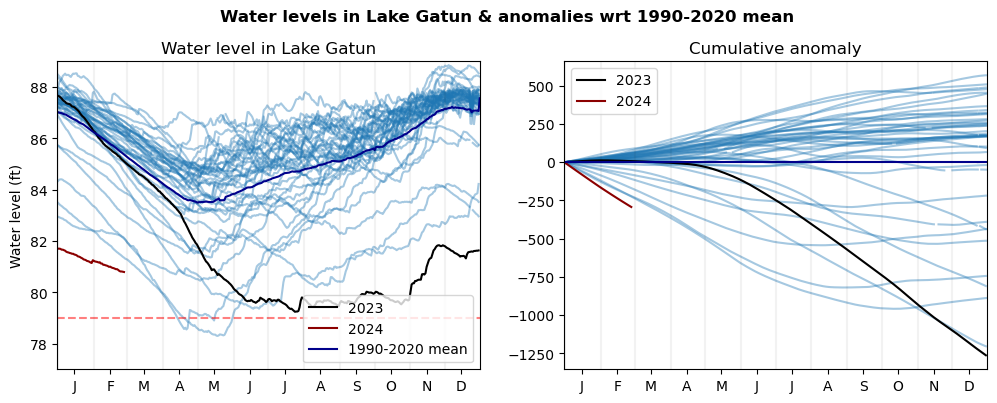

In [24]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]

for y in range(1981, 2023):
    ts_y = df.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ax.plot(ts_y.index, ts_y, color = "tab:blue", alpha = 0.4)

ts_y = df.loc[str(2023)]
ts_y.index = ts_y.index.day_of_year
ax.plot(ts_y.index, ts_y, color = "k", label = "2023")    

ts_y = df.loc[str(2024)]
ts_y.index = ts_y.index.day_of_year
ax.plot(ts_y.index, ts_y, color = "darkred", label = "2024")   

ax.plot(df_clim.index, df_clim, color = "darkblue", label = "1990-2020 mean")    
ax.set_ylim(77,89)
ax.axhline(79, color = "red", alpha = 0.5, ls = "--")
ax.legend()
ax.set_ylabel("Water level (ft)")
ax.set_title("Water level in Lake Gatun")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# cumulative anomaly
def ts_fun(ts): 
    zz = pd.merge(ts, df_clim, left_on = ts.index.day_of_year, right_index  = True)
    zz["diff"] = zz.level_x - zz.level_y
    return zz[["diff"]].cumsum()

ax = axs[1]

for y in range(1981, 2023):
    ts_y = ts_fun(df.loc[str(y)])
    ax.plot(ts_y.index.day_of_year, ts_y, color = "tab:blue", alpha = 0.4)

ts_y = ts_fun(df.loc[str(2023)])
ax.plot(ts_y.index.day_of_year, ts_y, color = "k", alpha = 1, label = "2023")

ts_y = ts_fun(df.loc[str(2024)])
ax.plot(ts_y.index.day_of_year, ts_y, color = "darkred", alpha = 1, label = "2024")

plt.axhline(0, color = "darkblue")
ax.set_title("Cumulative anomaly")
ax.legend()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:
    ax.set_xticks(labelticks); ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in gridlines]
    ax.set_xlabel("")
    ax.set_xlim(0,366)
    
plt.suptitle("Water levels in Lake Gatun & anomalies wrt 1990-2020 mean", fontweight = "bold", y = 1.01)

plt.savefig("fig/water-levels-with-anomaly.png")

# Evaluation of gridded data products

## Seasonal cycle

In [2]:
# load daily time series over the region
chirps, mswep, era5land = [xr.open_dataset("data/pr_monthly_"+ds+"-catchment.nc").pr.sel(time = slice(None, "2023")).resample(time = "MS").sum() for ds in ["chirps", "mswep", "era5land"]]

acp = pd.read_csv("data/pr_stations_infilled.csv", index_col = 0, parse_dates = [0])
acp = acp.mean(axis = 1).dropna(axis = 0, how = "all").to_xarray().rename("pr", index = "time")

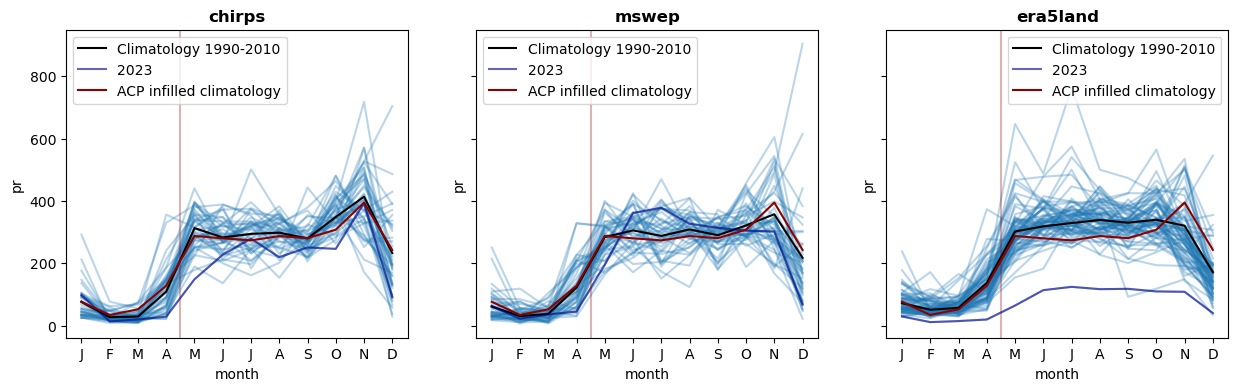

In [36]:
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (15,4), dpi = 100, sharex = True, sharey = True)

for i in range(3):
    ax = axs[i]
    ds = ["chirps", "mswep", "era5land", "acp"][i]
    ts = eval(ds)
    
    for y in np.unique(ts.time.dt.year.values):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.month, ts_y, color = "tab:blue", alpha = 0.3)

    ts.loc[slice("1990", "2020")].groupby("time.month").mean().plot(ax = ax, color = "k", label = "Climatology 1990-2010")
    ax.plot(ts_y.time.dt.month, ts_y, color = "darkblue", alpha = 0.6, label = "2023")
    
    acp.loc[slice("1990", "2020")].groupby("time.month").mean().plot(ax = ax, color = "darkred", label = "ACP infilled climatology")

    ax.set_xticks(range(1,13))
    ax.set_xticklabels(labels)

    ax.set_title(ds, fontweight = "bold")
    ax.legend()

    ax.axvline(4.5, color = "darkred", alpha = 0.3)
    
plt.savefig("fig/eval-obs_seasonal-cycle.png")

## Maps of gridded vs station data

In [3]:
# load data
obs_names = ["chirps", "mswep", "era5land"]
obs = [xr.open_dataset("data/"+ds+"_panama_monthly.nc").pr.resample(time = "AS-JAN").sum() for ds in obs_names]
obs = [da.where(da > 0) for da in obs]

# compute climatology
obs_clim = [da.sel(time = slice("1990", "2020")).mean("time") for da in obs]
obs_2023 = [ds.sel(time = "2023").squeeze(drop = True) for ds in obs]

In [4]:
# load station data, get annual mean (whole years only, require)
stn_pr = pd.read_csv("data/pr_stations_infilled.csv", index_col = 0, parse_dates = [0])
stn_ann = stn_pr.resample("AS-JAN").sum()
stn_ann = stn_ann.where(stn_pr.resample("AS-JAN").count() == 12)
stn_ann.index = stn_ann.index.year

# load lat & lon of all stations
stn_data = pd.read_csv("data/acp_stations.csv", index_col = 0)[["lon", "lat"]].dropna(axis = 0, how = "any")

# 2023 station data
stn_2023 = merge_byindex([stn_data, pd.DataFrame(stn_ann.loc[2023])]).dropna(axis = 0, how = "any")

# get station climatology (require min 20 years)
stn_clim = (stn_ann.loc[slice("1990", "2020")].mean().where(stn_ann.loc[slice("1990", "2020")].count() >= 20)).dropna(axis = 0, how = "any")
stn_clim = pd.DataFrame({"clim" : stn_clim})

stn_clim = merge_byindex([stn_data, stn_clim, stn_2023[[2023]]]).dropna(axis = 0, how = "any")

stn_clim["anom"] = stn_clim[2023] - stn_clim.clim

In [92]:
# absolute anomaly in each dataset
[(obs_2023[i] - obs_clim[i]).sel(lon = slice(xn,xx), lat = slice(yn,yx)).mean().values for i in range(3)]

[array(-685.952, dtype=float32),
 array(-209.83432, dtype=float32),
 array(-1895.32377583)]

### 2023 precipitation

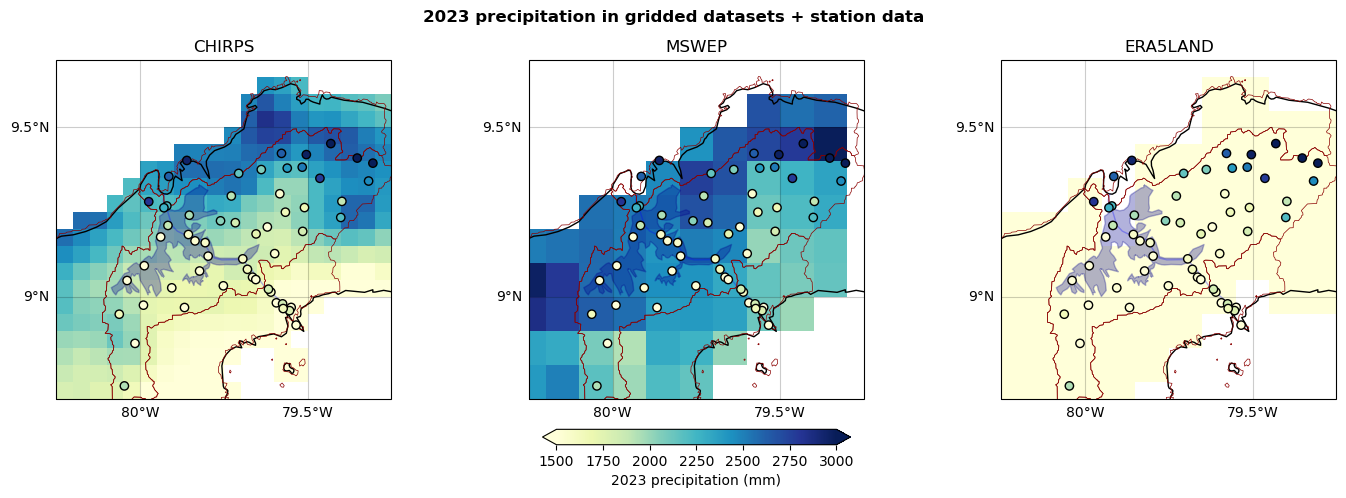

In [149]:
nobs = len(obs)
fig, axs = plt.subplots(ncols = nobs, figsize = (nobs*6,5), dpi = 100, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.05)
plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 1500, "vmax" : 3000}

for i in range(nobs):
    ds = obs_names[i]
    ax = axs[i]
    da = obs_2023[i]
    
    cbar = da.plot(ax = ax, **plot_kwargs, add_colorbar = False)
    ax.set_title(ds.upper())

    ax.scatter(stn_2023.lon, stn_2023.lat, c = stn_2023[2023], **plot_kwargs, zorder = 99, edgecolor = "k")

    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 0.5)


plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.04, pad = 0.08, label = "2023 precipitation (mm)", extend = "both")

plt.suptitle("2023 precipitation in gridded datasets + station data", fontweight = "bold")
plt.savefig("fig/eval-obs_2023-precipitation-maps.png")

### Climatology

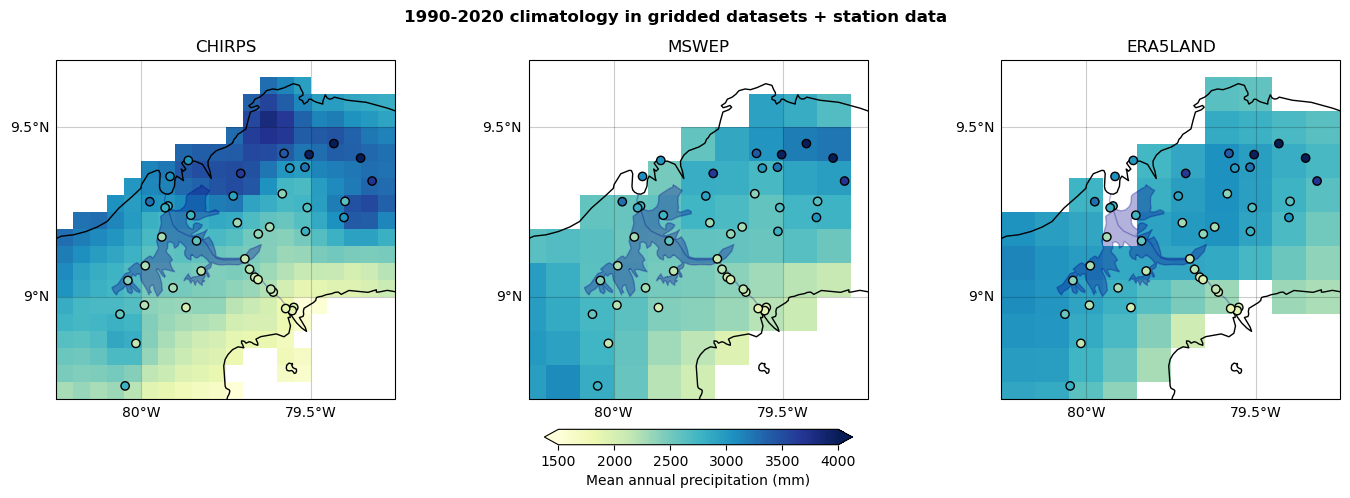

In [150]:
nobs = len(obs)
fig, axs = plt.subplots(ncols = nobs, figsize = (nobs*6,5), dpi = 100, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.05)
plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 1500, "vmax" : 4000}

for i in range(nobs):
    ds = obs_names[i]
    ax = axs[i]
    clim = obs_clim[i]

    cbar = clim.plot(ax = ax, **plot_kwargs, add_colorbar = False)
    ax.set_title(ds.upper())

    ax.scatter(stn_clim.lon, stn_clim.lat, c = stn_clim.clim, **plot_kwargs, zorder = 99, edgecolor = "k")

    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "darkblue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.04, pad = 0.08, label = "Mean annual precipitation (mm)", extend = "both")

plt.suptitle("1990-2020 climatology in gridded datasets + station data", fontweight = "bold")
plt.savefig("fig/eval-obs_climatology-maps.png")

### 2023 anomaly

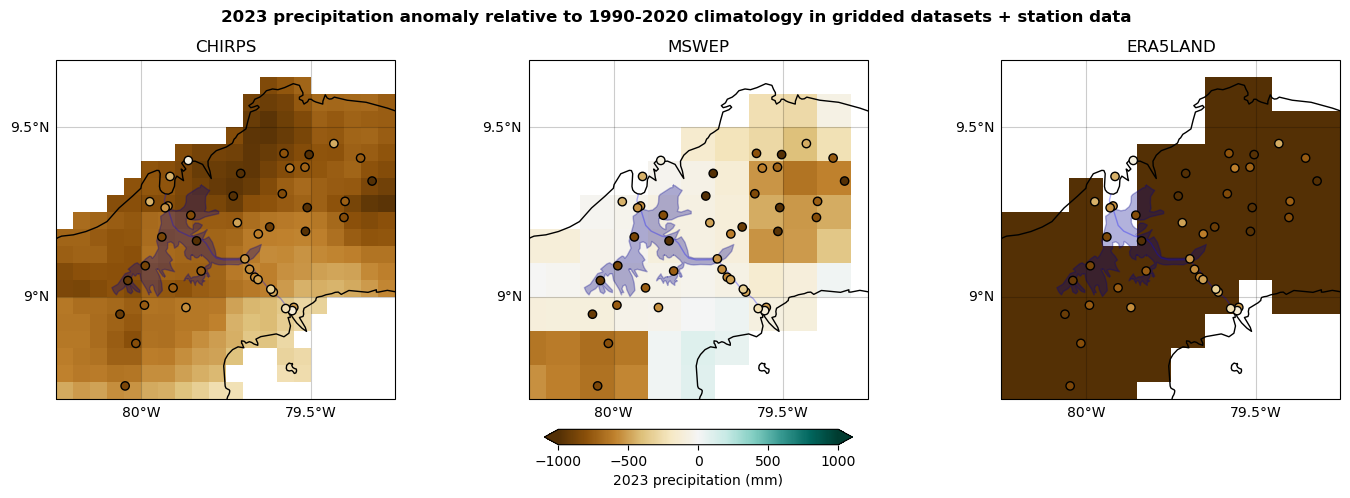

In [152]:
nobs = len(obs)
fig, axs = plt.subplots(ncols = nobs, figsize = (nobs*6,5), dpi = 100, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.05)
plot_kwargs = {"cmap" : "BrBG", "vmin" : -1000, "vmax" : 1000}

for i in range(nobs):
    ds = obs_names[i]
    ax = axs[i]
    anom = obs_2023[i] - obs_clim[i]
    
    cbar = anom.plot(ax = ax, **plot_kwargs, add_colorbar = False)
    ax.set_title(ds.upper())

    ax.scatter(stn_clim.lon, stn_clim.lat, c = stn_clim.anom, **plot_kwargs, zorder = 99, edgecolor = "k")

    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.04, pad = 0.08, label = "2023 precipitation (mm)", extend = "both")

plt.suptitle("2023 precipitation anomaly relative to 1990-2020 climatology in gridded datasets + station data", fontweight = "bold")
plt.savefig("fig/eval-obs_2023-anomaly-maps.png")

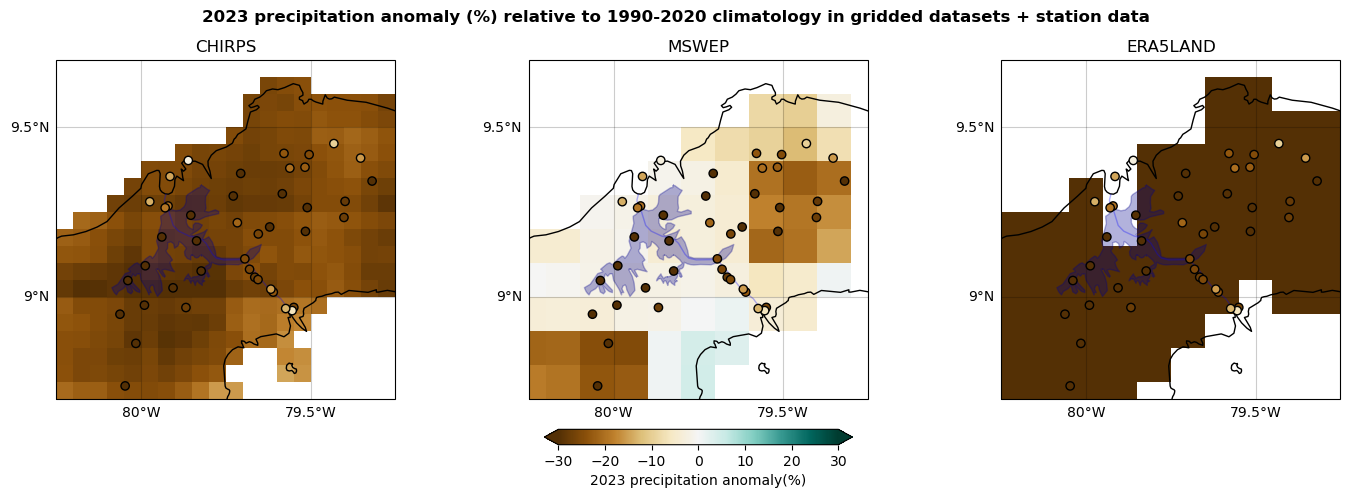

In [72]:
nobs = len(obs)
fig, axs = plt.subplots(ncols = nobs, figsize = (nobs*6,5), dpi = 100, subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.05)
plot_kwargs = {"cmap" : "BrBG", "vmin" : -30, "vmax" : 30}

for i in range(nobs):
    ds = obs_names[i]
    ax = axs[i]
    anom = (obs_2023[i] - obs_clim[i]) / obs_clim[i] * 100
    cbar = anom.plot(ax = ax, **plot_kwargs, add_colorbar = False)
    ax.set_title(ds.upper())

    ax.scatter(stn_clim.lon, stn_clim.lat, c = (stn_clim.anom / stn_clim.clim) * 100, **plot_kwargs, zorder = 99, edgecolor = "k")

    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.04, pad = 0.08, label = "2023 precipitation anomaly(%)", extend = "both")

plt.suptitle("2023 precipitation anomaly (%) relative to 1990-2020 climatology in gridded datasets + station data", fontweight = "bold")
plt.savefig("fig/eval-obs_2023-anomaly-relative-maps.png")

#### Seasonal anomaly

In [15]:
# load data
chirps = xr.open_dataset("data/chirps_panama_monthly.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn,yx))

In [19]:
ds = chirps.sel(time = [m <= 4 for m in chirps.time.dt.month]).resample(time = "AS-JAN").sum()
rs = chirps.sel(time = [m > 4 for m in chirps.time.dt.month]).resample(time = "AS-JAN").sum()

ds, rs = [da.where(da > 0) for da in [ds, rs]]

# compute climatology
ds_clim, rs_clim = [da.sel(time = slice("1990", "2020")).mean("time") for da in [ds, rs]]
ds_2023, rs_2023 = [da.sel(time = "2023").squeeze(drop = True) for da in [ds, rs]]

ds_anom = ds_2023 - ds_clim
rs_anom = rs_2023 - rs_clim

In [30]:
fig, axs = plt.subplots(ncols = 2, figsize = (8,4), subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]}, sharex = True, sharey = True)
plot_kwargs = {"cmap" : "BrBG", "vmin" : -1000, "vmax" : 1000, "add_colorbar" : False}

ds_anom.plot(ax = axs[0], **plot_kwargs)
cbar = rs_anom.plot(ax = axs[1], **plot_kwargs)

for ax in axs: ax.coastlines()

plt.colorbar(cbar, ax = axs)

## Ranges of anomalies

In [70]:
chirps = xr.open_dataset("data/chirps_panama_monthly.nc").sel(lon = slice(xn,xx), lat = slice(yn,yx)).resample(time = "AS-JAN").sum().pr
chirps_2023 = chirps.sel(time = "2023").where(chirps.sel(time = "2023") > 0)
chirps_clim = chirps.sel(time = slice("1990", "2020")).mean("time")
chirps_clim = chirps_clim.where(chirps_clim > 0)
chirps_anom = chirps_2023 - chirps_clim

print("Mean anomaly in CHIRPS gridded data:", chirps_anom.mean().values)
print("Range of anomalies in CHIRPS gridded data:", chirps_anom.quantile([0.025, 0.975]).values)
print("")
print("Relative anomaly in CHIRPS gridded data:", (chirps_anom.mean() / chirps_clim.mean()).values)
print("Range of relative anomalies in CHIRPS gridded data:", (chirps_anom / chirps_clim).quantile([0.025, 0.975]).values)

Mean anomaly in CHIRPS gridded data: -685.952
Range of anomalies in CHIRPS gridded data: [-949.46193848 -290.95731812]

Relative anomaly in CHIRPS gridded data: -0.25369087
Range of relative anomalies in CHIRPS gridded data: [-0.296121   -0.17476897]


In [71]:
# load station data, get annual mean (whole years only, require)
stn_pr = pd.read_csv("data/pr_stations_infilled.csv", index_col = 0, parse_dates = [0])
stn_ann = stn_pr.resample("AS-JAN").sum()
stn_ann = stn_ann.where(stn_pr.resample("AS-JAN").count() == 12)
stn_ann.index = stn_ann.index.year

# load lat & lon of all stations
stn_data = pd.read_csv("data/acp_stations.csv", index_col = 0)[["lon", "lat"]].dropna(axis = 0, how = "any")

# 2023 station data
stn_2023 = merge_byindex([stn_data, pd.DataFrame(stn_ann.loc[2023])]).dropna(axis = 0, how = "any")

# get station climatology (require min 20 years)
stn_clim = (stn_ann.loc[slice("1990", "2020")].mean().where(stn_ann.loc[slice("1990", "2020")].count() >= 20)).dropna(axis = 0, how = "any")
stn_clim = pd.DataFrame({"clim" : stn_clim})

stn_clim = merge_byindex([stn_data, stn_clim, stn_2023[[2023]]]).dropna(axis = 0, how = "any")

stn_clim["anom"] = stn_clim[2023] - stn_clim.clim

In [89]:
print("Mean anomaly in infilled station data:", stn_clim.anom.mean())
print("Range of anomalies in infilled station data:", stn_clim.anom.quantile([0.01,0.99]).values)
print("")
print("Relative anomaly in infilled station data:", (stn_clim.anom.mean() / stn_clim.clim.mean()))
print("Range of relative anomalies in infilled station data:", (stn_clim.anom / stn_clim.clim).quantile([0.025, 0.975]).values)

Mean anomaly in infilled station data: -706.1562168751749
Range of anomalies in infilled station data: [-1388.65975319   -99.50578183]

Relative anomaly in infilled station data: -0.26236653465669935
Range of relative anomalies in infilled station data: [-0.40533541 -0.06527716]


## Time series of rainy season total

In [34]:
datasets = ["chirps", "mswep", "era5land", "acp-filled-allstations"]

In [93]:
df = merge_byindex([pd.read_csv("ts/panama_pr-rs_"+ds+".dat", comment = "#", sep = " ", header = None, index_col = 0, names = [ds]) for ds in datasets]).loc[slice(1979,None)]

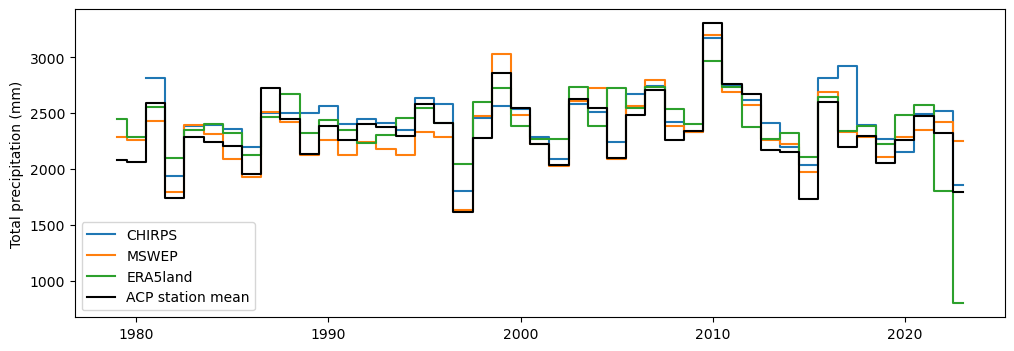

In [94]:
fig, ax = plt.subplots(ncols = 1, figsize = (12,4), dpi = 100)
df.plot(ax = ax, color = ["tab:blue", "tab:orange", "tab:green", "k"], drawstyle = "steps-mid")
ax.legend(["CHIRPS", "MSWEP", "ERA5land", "ACP station mean"])
ax.set_ylabel("Total precipitation (mm)")

# ax.set_title("Time series of May-December accumulated precipitation in gridded data products & station data")
plt.savefig("fig/eval-obs_rainy-season-timeseries.png")

# Contribution from seasonal precip to total deficit

In [131]:
datasets = ["chirps", "mswep", "era5land-1979-2021", "acp-filled-allstations"]

rs = merge_byindex([pd.read_csv("ts/panama_pr-rs_"+ds+".dat", comment = "#", sep = " ", header = None, index_col = 0, names = [ds]) for ds in datasets]).loc[slice(1979,None)]
ds = merge_byindex([pd.read_csv("ts/panama_pr-ds_"+ds+".dat", comment = "#", sep = " ", header = None, index_col = 0, names = [ds]) for ds in datasets]).loc[slice(1979,None)]

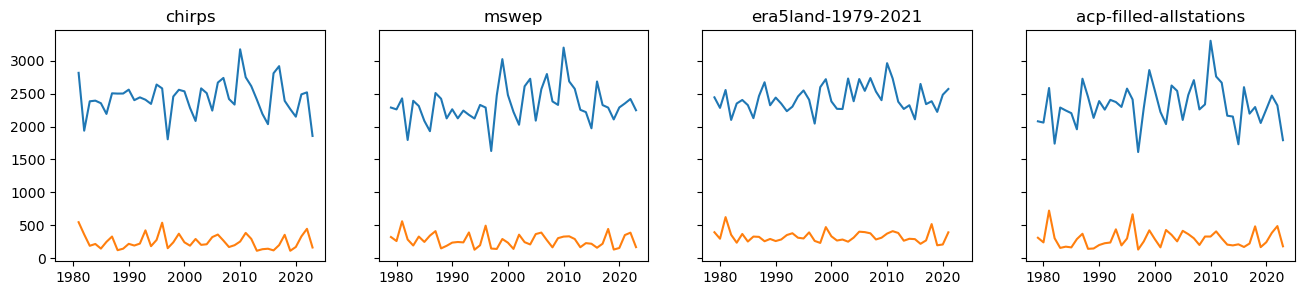

In [140]:
fig, axs = plt.subplots(ncols = 4, figsize = (16,3), dpi = 100, sharey = True, sharex = True)

for i in range(4):
    ax = axs[i]
    rs_i = rs.iloc[:,i]
    ds_i = ds.iloc[:,i]
    
    rs_i.plot(ax = ax)
    ds_i.plot(ax = ax)
    ax.set_title(datasets[i])

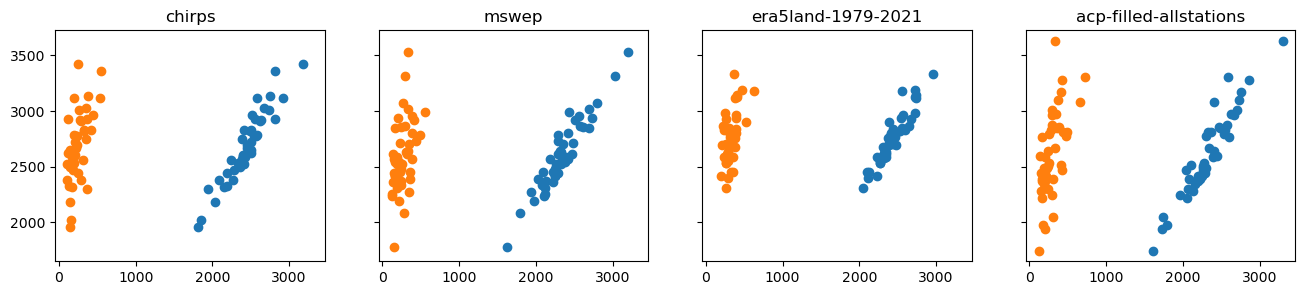

In [142]:
fig, axs = plt.subplots(ncols = 4, figsize = (16,3), dpi = 100, sharey = True, sharex = True)

for i in range(4):
    ax = axs[i]
    rs_i = rs.iloc[:,i]
    ds_i = ds.iloc[:,i]
    
    ax.scatter(rs_i, rs_i + ds_i)
    ax.scatter(ds_i, rs_i + ds_i)
    ax.set_title(datasets[i])

# Evaporation / PET

In [25]:
pet_ds = merge_byindex([pd.read_csv("data/pet-ds_"+ds+".csv", index_col = 0, skiprows = 1, names = [ds]) for ds in ["bci", "era5land", "terraclimate"]])
pet_rs = merge_byindex([pd.read_csv("data/pet-rs_"+ds+".csv", index_col = 0, skiprows = 1, names = [ds]) for ds in ["bci", "era5land", "terraclimate"]])

In [56]:
pet_rs

,bci,era5land,terraclimate
1950,NaN,397.973861,NaN
1951,NaN,420.352491,NaN
1952,NaN,412.659399,NaN
1953,NaN,460.206695,NaN
1954,NaN,451.207176,NaN
...,...,...,...
2019,410.55,468.139835,941.55760
2020,NaN,491.452110,932.98096
2021,NaN,464.982026,912.50256
2022,NaN,310.362714,920.38025


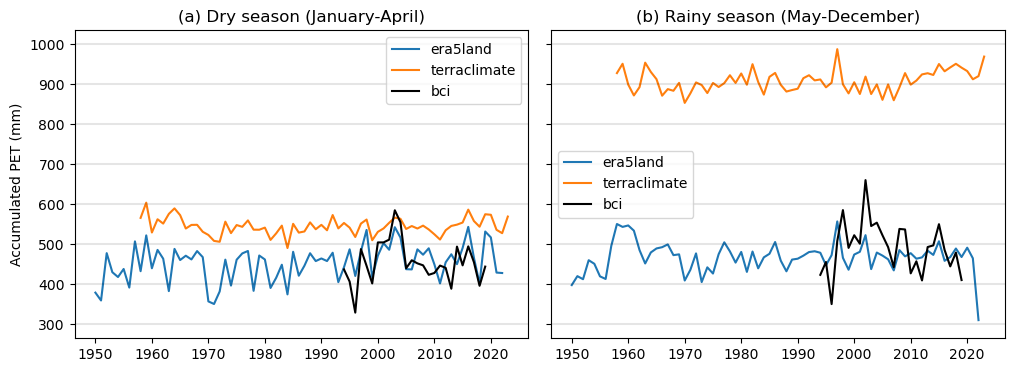

In [55]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, sharey = True)
plt.subplots_adjust(wspace = 0.05)

ax = axs[0]
pet_ds.iloc[:,1:].plot(ax = ax)
pet_ds.bci.plot(ax = ax, color = "k")
ax.set_title("(a) Dry season (January-April)")
ax.legend()
[ax.axhline(y, color = "k", alpha = 0.1) for y in range(300,1100, 100)]

ax = axs[1]
pet_rs.iloc[:,1:].plot(ax = ax)
pet_rs.bci.plot(ax = ax, color = "k")
ax.set_title("(b) Rainy season (May-December)")
ax.legend()
[ax.axhline(y, color = "k", alpha = 0.1) for y in range(300,1100, 100)]

axs[0].set_ylabel("Accumulated PET (mm)")

plt.savefig("fig/eval-obs_PET.png")

# Distances between ACP sites

In [78]:
from geopy.distance import distance

In [79]:
stn_data = pd.read_csv("data/acp_stations.csv", index_col = 0)[["lon", "lat"]].dropna(axis = 0, how = "any")
dists = np.array([[distance(stn_data.iloc[r].values, stn_data.iloc[s].values).km for r in range(len(stn_data))] for s in range(len(stn_data))])

(array([149., 309., 265., 204., 197., 180., 177., 165., 154., 126., 100.,
         87.,  70.,  46.,  42.,  29.,  37.,  28.,  24.,  10.,  15.,  15.,
         11.,  13.,  13.,   7.,   3.,   3.,   3.,   1.,   2.]),
 array([  0.        ,   4.56740425,   9.1348085 ,  13.70221274,
         18.26961699,  22.83702124,  27.40442549,  31.97182974,
         36.53923399,  41.10663823,  45.67404248,  50.24144673,
         54.80885098,  59.37625523,  63.94365947,  68.51106372,
         73.07846797,  77.64587222,  82.21327647,  86.78068071,
         91.34808496,  95.91548921, 100.48289346, 105.05029771,
        109.61770196, 114.1851062 , 118.75251045, 123.3199147 ,
        127.88731895, 132.4547232 , 137.02212744, 141.58953169]),
 <BarContainer object of 31 artists>)

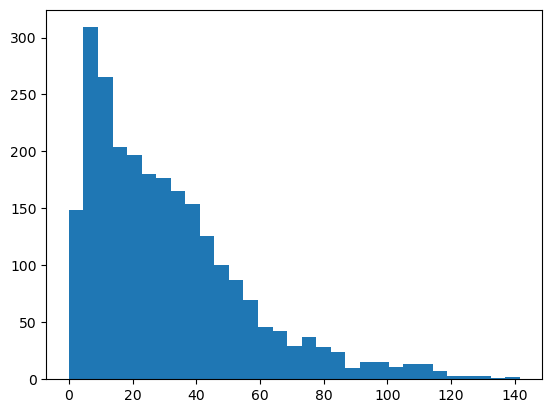

In [85]:
# histogram of distances
plt.hist(dists[np.triu_indices(len(dists), k = 1)], bins = "fd")